# Nara Backtesting Platform

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from backtest import Backtest, DisplayBacktest, Strategy

### Define your strategies

In [2]:
class MovingAverageStrategy(Strategy):
    def __init__(self, name, data, short_window, long_window):
        super().__init__(name, data)
        self.short_window = short_window
        self.long_window = long_window
        self.tickers = data.columns

        # Compute moving averages for each ticker
        for ticker in self.tickers:
            self.data[f'{self.strategy_name}_{ticker}_short_ma'] = self.data[ticker].rolling(window=self.short_window).mean()
            self.data[f'{self.strategy_name}_{ticker}_long_ma'] = self.data[ticker].rolling(window=self.long_window).mean()

    def calculate_signal(self):
        for ticker in self.tickers:
            self.data[f'{self.strategy_name}_{ticker}_signal'] = 0.0
            self.data[f'{self.strategy_name}_{ticker}_signal'][self.short_window:] = np.where(
                self.data[f'{self.strategy_name}_{ticker}_short_ma'][self.short_window:] > self.data[f'{self.strategy_name}_{ticker}_long_ma'][self.short_window:], 1.0, 0.0
            )

    def calculate_positions(self):
        positions_list = []
        for ticker in self.tickers:
            positions = pd.DataFrame({
                'time': self.data.index,
                'book': self.strategy_name,
                'ticker': ticker,
                'units': np.where(self.data[f'{self.strategy_name}_{ticker}_signal'] == 1.0, 10, -10)
            })
            positions_list.append(positions)
        return pd.concat(positions_list)

### Fetch your data and format it as followed

[*********************100%%**********************]  2 of 2 completed


<Axes: xlabel='Date'>

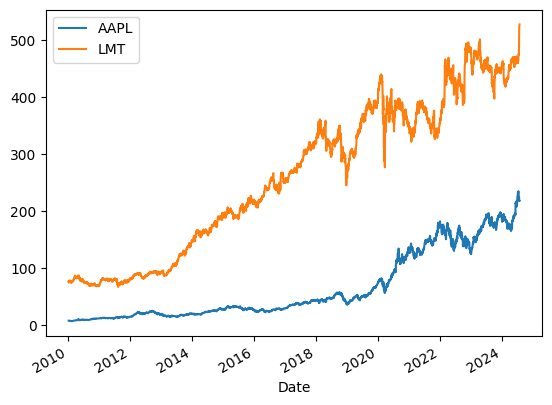

In [3]:
# Define tickers and date range
import pandas as pd
import pandas as pd
tickers = ['AAPL', 'LMT']
start_date = '2010-01-01'
end_date = '2025-01-01'

# Fetch data
data = yf.download(tickers, start=start_date, end=end_date)['Close']

# Format
data.columns = tickers # Ensure the columns are well named
data = data.dropna() # Drop rows with missing values
data.index = pd.to_datetime(data.index) # Convert index to datetime format
data = data.sort_index() # Sort the data by index

# Display
data.plot()

In [4]:
data

,AAPL,LMT
Date,,
2010-01-04,7.643214,76.849998
2010-01-05,7.656429,77.650002
2010-01-06,7.534643,76.510002
2010-01-07,7.520714,74.410004
2010-01-08,7.570714,75.610001
...,...,...
2024-07-23,225.009995,501.290009
2024-07-24,218.539993,515.200012
2024-07-25,217.490005,521.400024


In [5]:
# Initialize and run backtest
strategy1 = MovingAverageStrategy(name="StrategyShortMA", data=data, short_window=5, long_window=21)
strategy2 = MovingAverageStrategy(name="StrategyLongMA", data=data, short_window=20, long_window=50)
strategies = [strategy1, strategy2] 
weights = {"StrategyShortMA": 0.7, "StrategyLongMA": 0.3}

backtest = Backtest(data, strategies, weights)

100%|██████████| 3666/3666 [01:23<00:00, 44.15it/s]


In [6]:
# Plot results
display = DisplayBacktest(backtest)
display.plot_book("StrategyShortMA")
display.plot_cumulative_pnl_per_book()
display.plot_cumulative_pnl()
display.plot_individual_pnl()
display.plot_pnl_distribution()

# Get yearly and monthly metrics
yearly_metrics = display.get_metrics(book='StrategyShortMA', resample_period='Y')  # Yearly metrics
monthly_metrics = display.get_metrics(book='StrategyShortMA', resample_period='M')  # Monthly metrics

# Export excel
backtest.export_excel("backtest_results.xlsx")

Backtest results exported to backtest_results.xlsx


In [7]:
yearly_metrics

,PnL,Volatility,Max Drawdown,Sharpe Ratio
time,,,,
2010-01-01,-83.446436,152.334439,1.920255,-0.547784
2011-01-01,-116.700239,172.715135,2.251956,-0.675680
2012-01-01,-24.489298,145.836601,1.271617,-0.167923
2013-01-01,224.932270,189.550838,1.265595,1.186659
2014-01-01,-460.942421,292.879850,6.935345,-1.573828
2015-01-01,-697.449875,353.996885,59.981681,-1.970215
2016-01-01,340.150375,420.414597,1.547654,0.809083
2017-01-01,-115.224476,335.580429,3.055974,-0.343359
2018-01-01,629.975739,802.450412,1.805016,0.785065


In [8]:
monthly_metrics

,PnL,Volatility,Max Drawdown,Sharpe Ratio
time,,,,
2010-01-01,26.653628,194.013382,1.920255,0.137380
2010-02-01,-27.078619,129.026399,-0.000000,-0.209869
2010-03-01,65.449986,134.451050,0.330068,0.486794
2010-04-01,-22.982244,154.906607,4.770298,-0.148362
2010-05-01,-39.217920,281.124563,4.710155,-0.139504
...,...,...,...,...
2024-03-01,359.000092,589.546753,0.289271,0.608943
2024-04-01,-64.300232,742.735219,6.089136,-0.086572
2024-05-01,-79.099884,769.794926,1.311417,-0.102754
